# Data libraries in PyDePSI

PyDePSI uses two data libraries for processing:

- [`sarxarray`](https://github.com/MotionbyLearning/sarxarray) for handling coregistered SLC or interferogram stacks
- [`stm`](https://github.com/MotionbyLearning/stm) for handling SpaceTime Matrix

In this notebook, we will demonstrate an example workflow using these two data libraries to do:

1. Lazily load a coregistered interferogram stack
2. Make a Mean Reflection Map (MRM)
3. Perform Persistent Scatter (PS) selection and save the results t as a SpaceTime Matrix (STM)
4. Enrich selected STM with contextual data

### Data used for this notebook
To run this notebook, you will need the following two datasets:
- [Sentinel-1 interferogram stack over Amsterdam](https://figshare.com/ndownloader/files/41012180)
- [BAG building polygons in Amsterdam](https://figshare.com/ndownloader/files/41012444)

Please retrieve this dataset and save it in the `data` directory in your working directory.

### Scale up this example to HPC (Optional)
This notebook can run on a local laptop to process a relatively smaller dataset. But it can also be scaled up to process larger datasets by using HPC. It supports using [JupyterDaskOnSLURM](https://github.com/RS-DAT/JupyterDaskOnSLURM), which is one of the tools in [RS-DAT](https://github.com/RS-DAT/) platform, to scale up. Please refer to the [user guide](https://github.com/RS-DAT/JupyterDaskOnSLURM/blob/main/user-guide.md) to execute this notebook on HPC.

## Step 0: Setup a Dask SLURMCluster (Optional)

You can ignore this step if you are running on a local laptop.

If you are running on an HPC environment, you can setup a Dask [SLURMCluster](https://jobqueue.dask.org/en/latest/generated/dask_jobqueue.SLURMCluster.html) to perform parallel processing. To set up the SLURMCluster, you can either follow the [Dask documentation](https://jobqueue.dask.org/en/latest/generated/dask_jobqueue.SLURMCluster.html) to set it manually, or follow the RSDAT [user guide](https://github.com/RS-DAT/JupyterDaskOnSLURM/blob/main/user-guide.md) to set it with a Dask plugin in Jupyter Server

Below is an example of connecting to a `SLURMCluster` hosted at `tcp://10.0.1.124:35589`.

In [1]:
# One example of setting up a Dask client connecting to a SlurmCluster

# from dask.distributed import Client
# client = Client("tcp://10.0.2.109:33771")
# client

<Client: 'tcp://10.0.2.109:33771' processes=16 threads=64, memory=256.00 GiB>

## Step1: Load a SLC stack using SarXarray

In [2]:
import os
from pathlib import Path

import numpy as np
import sarxarray

cwd = Path(os.getcwd())

In [3]:
# Path to the interferogram dataset
path = Path(cwd / 'data/nl_amsterdam_s1_asc_t088')

# Make a list of SLCs to read
f_slc = 'cint_srd.raw'
list_slcs = [p for p in path.rglob('*_cint_srd.raw')]
list_slcs.sort()

# Geo-referenced coordinates
f_lat = [path / 'lat.raw']
f_lon = [path / 'lon.raw']

# Metadata of the stack, assume known.
shape=(2000, 4000)

In [4]:
# Define reading chunks
reading_chunks = (500,500)

# Load complex data
stack = sarxarray.from_binary(list_slcs, shape, dtype=np.complex64, chunks=reading_chunks)

# Load coordinates
lat = sarxarray.from_binary(f_lat, shape, vlabel="lat", dtype=np.float32, chunks=reading_chunks)
lon = sarxarray.from_binary(f_lon, shape, vlabel="lon", dtype=np.float32, chunks=reading_chunks)
stack = stack.assign_coords(lat = (("azimuth", "range"), lat.squeeze().lat.data), lon = (("azimuth", "range"), lon.squeeze().lon.data))
stack

<xarray.Dataset>
Dimensions:    (azimuth: 2000, range: 4000, time: 10)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range      (range) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    lat        (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon        (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>

## Step 2: Making a MRM

In [5]:
mrm = stack.slcstack.mrm()
mrm

<xarray.DataArray 'amplitude' (azimuth: 2000, range: 4000)>
dask.array<mean_agg-aggregate, shape=(2000, 4000), dtype=float32, chunksize=(500, 500), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 ... 3993 3994 3995 3996 3997 3998 3999
    lat      (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon      (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>

In [6]:
mrm = mrm.compute()

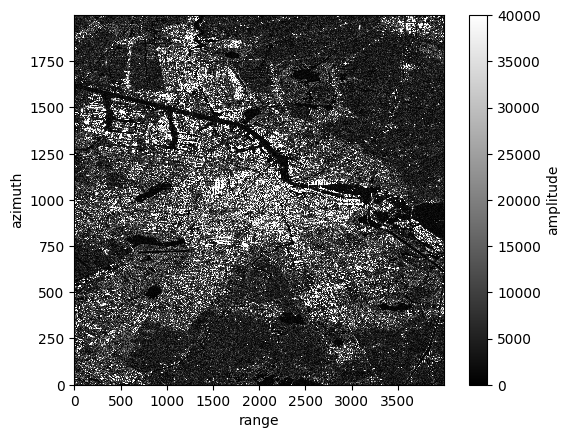

In [7]:
# Visualize
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.imshow(mrm)
ax.set_aspect(2)
im = mrm.plot(ax=ax, cmap='gray')
im.set_clim([0, 40000])

## Step3: PS seletion

In [8]:
stmat = stack.slcstack.point_selection(threshold=4, method="amplitude_dispersion",chunks=5000)
stmat

<xarray.Dataset>
Dimensions:    (time: 10, points: 316762)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    lat        (points) float32 dask.array<chunksize=(5000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(5000,), meta=np.ndarray>
    azimuth    (points) int64 dask.array<chunksize=(5000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(5000,), meta=np.ndarray>
Dimensions without coordinates: points
Data variables:
    complex    (points, time) complex64 dask.array<chunksize=(5000, 10), meta=np.ndarray>
    amplitude  (points, time) float32 dask.array<chunksize=(5000, 10), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(5000, 10), meta=np.ndarray>

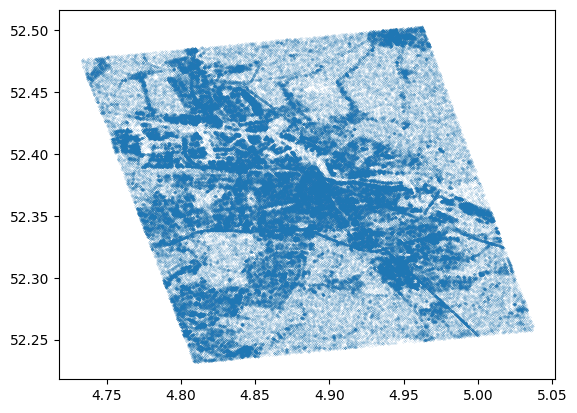

In [9]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
plt.scatter(stmat.lon.data, stmat.lat.data, s=0.005)

In [10]:
# Export to Zarr
stmat.to_zarr("stm.zarr", mode="w") # overwrite for demo

## Step4: STM enrichment

In [11]:
import xarray as xr

path_stm = Path('./stm.zarr')
stm_demo = xr.open_zarr(path_stm)
stm_demo

<xarray.Dataset>
Dimensions:    (points: 316762, time: 10)
Coordinates:
    azimuth    (points) int64 dask.array<chunksize=(5000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(5000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(5000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(5000,), meta=np.ndarray>
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: points
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(5000, 10), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(5000, 10), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(5000, 10), meta=np.ndarray>

In [12]:
# Path to the BRP polygon of NL
# Need a abs path for cluster processing
path_polygon = Path('/project/caroline/Public/demo_sarxarray/data/bag_light_AMS_WGS84.gpkg')

In [13]:
# Data enrichment
fields_to_query = ['bouwjaar']

# When AoI is small and less number of chunks: directly feed in the polygon file. Multi-process can be blocked by file IO
stm_demo = stm_demo.stm.enrich_from_polygon(path_polygon, fields_to_query)

In [14]:
# Select PS in sied polygons
stm_demo_subset = stm_demo.stm.subset(method='polygon', polygon=path_polygon)
stm_demo_subset

<xarray.Dataset>
Dimensions:    (time: 10, points: 85315)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    azimuth    (points) int64 dask.array<chunksize=(5000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(5000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(5000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(5000,), meta=np.ndarray>
Dimensions without coordinates: points
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(5000, 10), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(5000, 10), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(5000, 10), meta=np.ndarray>
    bouwjaar   (points) object dask.array<chunksize=(5000,), meta=np.ndarray>

In [15]:
# Compute the construction year
bouwjaar = stm_demo_subset['bouwjaar'].compute()

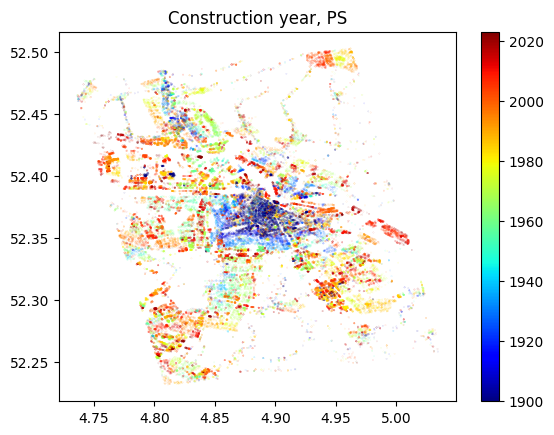

2023-06-01 11:51:53,744 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [16]:
# Visualize results
import matplotlib.cm as cm
from matplotlib import pyplot as plt

colormap = cm.jet

fig, ax = plt.subplots()
plt.title("Construction year, PS")
plt.scatter(stm_demo_subset.lon.data, stm_demo_subset.lat.data, c=bouwjaar, s=0.002, cmap=colormap)
plt.clim([1900, 2023])
plt.colorbar()